The essence of machine learning and deep learning is to take *data from the past*, build an algorithm to *discover the pattern* in it to *predict the future* 

![basic pytorch workflow](./docs/images/01-pytorch-workflow/01_a_pytorch_workflow.png "Pytorhc workflow")

# 1. Data (preparing and loading)


We start by importing libraries we need

In [2]:
# Import pytorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check pytorch version
torch.__version__


'2.5.1+cu124'

Making device agnostic

In [3]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [4]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create range value
start = 0
end = 1
step = 0.02

# Create X (features) and y (labels)
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias
for i in range(10):
    print(f'X = {X[i]} ~ y ={y[i]}')

X = tensor([0.]) ~ y =tensor([0.3000])
X = tensor([0.0200]) ~ y =tensor([0.3140])
X = tensor([0.0400]) ~ y =tensor([0.3280])
X = tensor([0.0600]) ~ y =tensor([0.3420])
X = tensor([0.0800]) ~ y =tensor([0.3560])
X = tensor([0.1000]) ~ y =tensor([0.3700])
X = tensor([0.1200]) ~ y =tensor([0.3840])
X = tensor([0.1400]) ~ y =tensor([0.3980])
X = tensor([0.1600]) ~ y =tensor([0.4120])
X = tensor([0.1800]) ~ y =tensor([0.4260])


Now we split the data into training and test sets with ratio 80/20, 80% for training and 20% for testing

In [5]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(f'Length of X_train: {len(X_train)}\tLength of y_train: {len(y_train)}')
print(f'Length of X_test: {len(X_test)}\tLength of y_test: {len(y_test)}')

Length of X_train: 40	Length of y_train: 40
Length of X_test: 10	Length of y_test: 10


Let's visualize the data

In [6]:
from torch import Tensor

def plot_predictions(train_data:Tensor,
                     train_label:Tensor,
                     test_data:Tensor,
                     test_label:Tensor,
                     predictions:Tensor=None,
                     ):
    """
    Plots training data, test data and compares prediction
    """
    plt.figure(figsize=(10,7))
    
    # Plot training data in blue
    plt.scatter(train_data,train_label,c='b', s=4, label='Training data')
    
    # Plot test data in green
    plt.scatter(test_data, test_label,c='g', s=4, label='Test data')
    
    if predictions is not None:
        # Plot the predictions in red
        plt.scatter(test_data, predictions,c='r',s=4, label='Predictions')
        
    # Show the legend
    plt.legend(prop={'size':14})

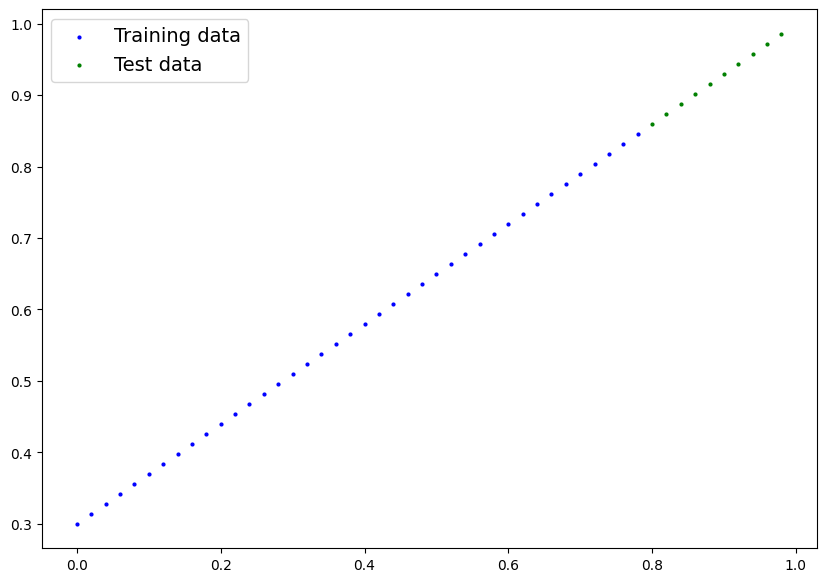

In [7]:
plot_predictions(train_data=X_train, train_label=y_train, test_data=X_test, test_label=y_test)

# 2. Build model

We'll create a model but instead of defining the weight and bias parameters of our model manually using `nn.Parameter()`, we'll use `nn.Linear(in_features, out_features)` to do it for us.
* `in_feature` is the number of dimensions your input data has
* `out_feature` is the number of dimension you'd like the output to be


In [8]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
        
    # Define the forward computation
    def forward(self, x: Tensor) -> Tensor:
        return self.linear_layer(x)
    
# Set manual seed when creating the model
torch.manual_seed(42)
model_1 = LinearRegressionModel()
model_1, model_1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

Since we run on `CUDA` device so let's put out model on the GPU

In [9]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [10]:
# Set model to GPU
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

# 3. Training

Before training, we have to define out **loss function** and our **optimizer**. In this example, we will use `nn.L1Loss()` and `torch.optim.SGD()`

In optimizer, we have to pass `model.parameters()` for optimizer so it will adjust them during the training

In [11]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(
    params=model_1.parameters(), lr=0.01
)

In [12]:
# Set the number of epochs
epochs = 1000

# Move our training set and test set to available device
X_train_cuda = X_train.to(device)
y_train_cuda = y_train.to(device)
X_test_cuda = X_test.to(device)
y_test_cuda = y_test.to(device)


for epoch in range(epochs):
    ### Training
    model_1.train()
    
    # 1. Forward pass
    y_pred = model_1(X_train_cuda)
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train_cuda)
    
    # 3. Zero grad optimizer
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Step the optimizer
    optimizer.step()
    
    ### Testing
    model_1.eval()
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test_cuda)
        
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred,y_test_cuda)
        
    
    if epoch%10 == 0:
        print(f'Epoch: {epoch} |\tTrain loss: {loss} |\tTest loss: {test_loss} ')

Epoch: 0 |	Train loss: 0.5551779866218567 |	Test loss: 0.5739762187004089 
Epoch: 10 |	Train loss: 0.439968079328537 |	Test loss: 0.4392664134502411 
Epoch: 20 |	Train loss: 0.3247582018375397 |	Test loss: 0.30455657839775085 
Epoch: 30 |	Train loss: 0.20954833924770355 |	Test loss: 0.16984669864177704 
Epoch: 40 |	Train loss: 0.09433845430612564 |	Test loss: 0.03513690456748009 
Epoch: 50 |	Train loss: 0.023886388167738914 |	Test loss: 0.04784907028079033 
Epoch: 60 |	Train loss: 0.019956795498728752 |	Test loss: 0.045803118497133255 
Epoch: 70 |	Train loss: 0.016517987474799156 |	Test loss: 0.037530567497015 
Epoch: 80 |	Train loss: 0.013089174404740334 |	Test loss: 0.02994490973651409 
Epoch: 90 |	Train loss: 0.009653178043663502 |	Test loss: 0.02167237363755703 
Epoch: 100 |	Train loss: 0.006215683650225401 |	Test loss: 0.014086711220443249 
Epoch: 110 |	Train loss: 0.00278724217787385 |	Test loss: 0.005814164876937866 
Epoch: 120 |	Train loss: 0.0012645035749301314 |	Test loss: 0.

# 4. Make predictions

In [13]:
# Turn model into evalutation mode
model_1.eval()

# Make predictions on test data
with torch.inference_mode():
    y_preds_cuda = model_1(X_test_cuda)
    
for i in range(len(X_test_cuda)):
    print(f'X = {X_test_cuda[i]} ~ y = {y_preds_cuda[i]}')

X = tensor([0.8000], device='cuda:0') ~ y = tensor([0.8600], device='cuda:0')
X = tensor([0.8200], device='cuda:0') ~ y = tensor([0.8739], device='cuda:0')
X = tensor([0.8400], device='cuda:0') ~ y = tensor([0.8878], device='cuda:0')
X = tensor([0.8600], device='cuda:0') ~ y = tensor([0.9018], device='cuda:0')
X = tensor([0.8800], device='cuda:0') ~ y = tensor([0.9157], device='cuda:0')
X = tensor([0.9000], device='cuda:0') ~ y = tensor([0.9296], device='cuda:0')
X = tensor([0.9200], device='cuda:0') ~ y = tensor([0.9436], device='cuda:0')
X = tensor([0.9400], device='cuda:0') ~ y = tensor([0.9575], device='cuda:0')
X = tensor([0.9600], device='cuda:0') ~ y = tensor([0.9714], device='cuda:0')
X = tensor([0.9800], device='cuda:0') ~ y = tensor([0.9854], device='cuda:0')


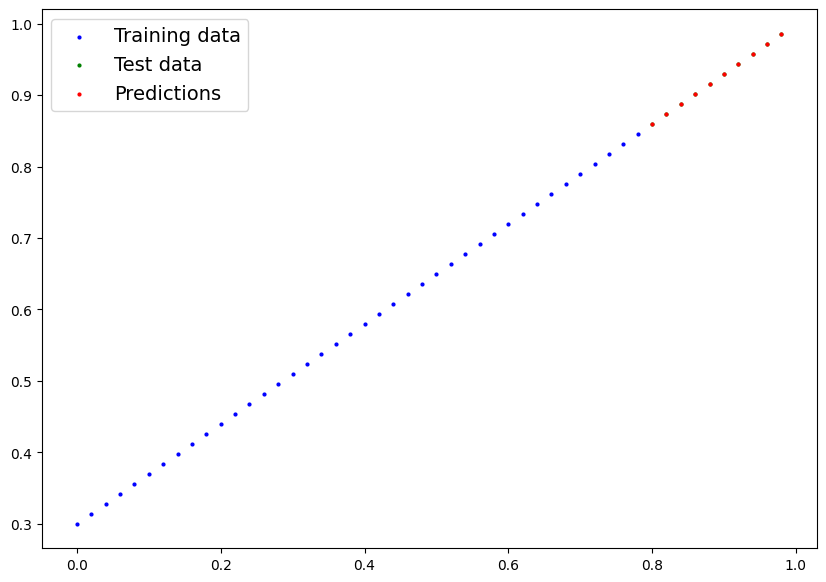

In [14]:
y_preds = y_preds_cuda.cpu()

# plot predictions
plot_predictions(
    train_data=X_train,
    train_label=y_train,
    test_data=X_test,
    test_label=y_test,
    predictions=y_preds
)

# 5. Saving and loading a model

In [15]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# 3. Save the model state_dict
print(f'Saving model to {MODEL_SAVE_PATH}')
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

Saving model to models\01_pytorch_workflow_model_1.pth


So we have save out model, let's try to load it back in.
1. Create new instance of `LinearRegressionModel()` class
2. Load in the model using `nn.Module.load_state_dict()`

In [16]:
# Create a new instance of LinearRegressionModel 
loaded_model_1 = LinearRegressionModel()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to available device
loaded_model_1.to(device)

# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds_cuda = loaded_model_1(X_test_cuda)
    
loaded_model_1_preds_cuda == y_preds_cuda

C:\Users\KietVu\AppData\Local\Temp\ipykernel_27672\915523248.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')